In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 18.2 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
import datasets
import pandas as pd
# Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

In [ ]:
dataset = datasets.load_dataset("ag_news")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
train , validation = train_test_split(dataset['train'].to_pandas(), test_size=0.065, random_state=42)

In [ ]:
Categories = ["World", "Sports", "Business", "Sci/Tech"]
Categories

['World', 'Sports', 'Business', 'Sci/Tech']

In [ ]:
def get_balanced_dataset(dataset, percentage):
    import warnings
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    dataset = pd.DataFrame(dataset)
    dataset = dataset[['text', 'label']]
    dataset = dataset.groupby("label").apply(lambda x: x.sample(frac=percentage)).reset_index(drop=True)
    return dataset

In [ ]:
perc_train = 0.14
perc = 0.25

train_df = get_balanced_dataset(train, perc_train)
test_df = get_balanced_dataset(dataset["test"], perc)
valid_df = get_balanced_dataset(validation, perc)

train_df['Categories'] = train_df['label'].apply(lambda x: Categories[x])

# Contagem de labels em cada dataset
count_train = train_df['label'].value_counts()
count_test = test_df['label'].value_counts()
count_valid = valid_df['label'].value_counts()

# Encontrando a menor contagem em cada dataset
min_count_train = count_train.min()
min_count_test = count_test.min()
min_count_valid = count_valid.min()

# Fazendo o resample (downsampling) para o dataset de treino
train_df = pd.concat([
    train_df[train_df['label'] == label].sample(n=min_count_train, random_state=42)
    for label in train_df['label'].unique()
])

# Fazendo o resample (downsampling) para o dataset de teste
test_df = pd.concat([
    test_df[test_df['label'] == label].sample(n=min_count_test, random_state=42)
    for label in test_df['label'].unique()
])

# Fazendo o resample (downsampling) para o dataset de validação
valid_df = pd.concat([
    valid_df[valid_df['label'] == label].sample(n=min_count_valid, random_state=42)
    for label in valid_df['label'].unique()
])


training_set = list(zip(train_df["text"], train_df["label"]))
test_set = list(zip(test_df["text"], test_df["label"]))

In [ ]:
test_df['Categories'] = test_df['label'].apply(lambda x: Categories[x])

<Axes: title={'center': 'Distribuição das categorias - Treino AGNews'}, xlabel='label'>

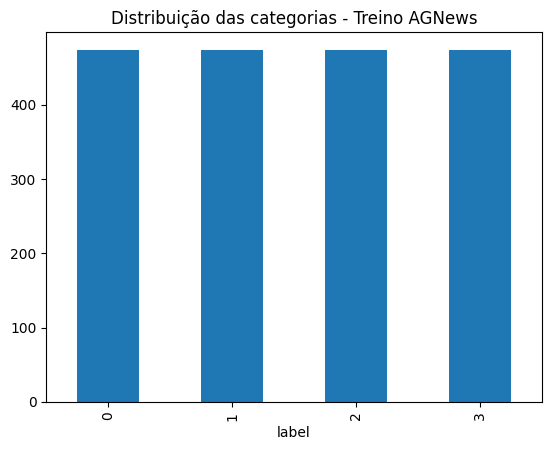

In [ ]:
pd.DataFrame(valid_df)['label'].value_counts().plot(kind='bar', title='Distribuição das categorias - Treino AGNews')

In [ ]:
train_df['size'] = train_df['text'].apply(len)
test_df['size'] = test_df['text'].apply(len)
valid_df['size'] = valid_df['text'].apply(len)

In [ ]:
train_df

,text,label,Categories,size
1593,Australia holds security meeting as warns of s...,0,World,304
465,Space Capsule Crashes in Utah The Genesis spac...,0,World,157
1615,"Typhoon Ma-On Nears Japan, May Strike Tokyo T...",0,World,266
490,Russian Hostel Fire Kills at Least 19 MOSCOW ...,0,World,197
1926,Padres Blank Dodgers 3-0 LOS ANGELES - Adam Ea...,0,World,357
...,...,...,...,...
13023,Capsule from Genesis Space Probe Crashes in Ut...,3,Sci/Tech,204
12251,IT departments turn to gateways to manage IM S...,3,Sci/Tech,331
13954,Violence Tackled at Internet Gaming Parlors By...,3,Sci/Tech,266
13423,"Microsoft, Polycom work on collaboration apps ...",3,Sci/Tech,170


In [ ]:
# Defining pre-processing parameters
max_len = train_df['size'].max()
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = int(train_df['size'].mean())

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size,
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(train_df['text'])

In [ ]:
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

31205

In [ ]:
training_sequences = tokenizer.texts_to_sequences(train_df['text'])
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test_df['text'])
test_padded = pad_sequences(test_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

In [ ]:
valid_sequences = tokenizer.texts_to_sequences(valid_df['text'])
valid_padded = pad_sequences(valid_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

In [ ]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', test_padded.shape)
print('Shape of testing tensor: ', valid_padded.shape)

Shape of training tensor:  (15668, 1006)
Shape of testing tensor:  (1900, 1006)
Shape of testing tensor:  (1896, 1006)


In [ ]:
num_classes = 4

### Dense Model

In [ ]:
# Define parameter
embedding_dim = 16
drop_value = 0.2
n_dense = 24
# Define Dense Model Architecture
model = Sequential()
model.add(Embedding(vocab_size,
                    embedding_dim,
                    input_length = max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1006, 16)          3760      
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 100       
                                                                 
Total params: 4268 (16.67 KB)
Trainable params: 4268 (16.67 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])

In [ ]:
model_name = "dense_model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.000001)

In [ ]:
num_epochs = 100
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded,
                    train_df['label'],
                    epochs=num_epochs,
                    validation_data=(valid_padded, valid_df['label']),
                    callbacks=[checkpoint,earlystopping,learning_rate_reduction],
                    verbose=2)

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.38410, saving model to dense_model.keras
490/490 - 4s - loss: 1.3857 - accuracy: 0.2597 - val_loss: 1.3841 - val_accuracy: 0.2505 - lr: 0.0010 - 4s/epoch - 8ms/step
Epoch 2/100

Epoch 2: val_loss improved from 1.38410 to 1.36305, saving model to dense_model.keras
490/490 - 2s - loss: 1.3776 - accuracy: 0.3095 - val_loss: 1.3631 - val_accuracy: 0.3281 - lr: 0.0010 - 2s/epoch - 5ms/step
Epoch 3/100

Epoch 3: val_loss improved from 1.36305 to 1.23061, saving model to dense_model.keras
490/490 - 2s - loss: 1.3076 - accuracy: 0.4156 - val_loss: 1.2306 - val_accuracy: 0.4884 - lr: 0.0010 - 2s/epoch - 5ms/step
Epoch 4/100

Epoch 4: val_loss improved from 1.23061 to 1.09435, saving model to dense_model.keras
490/490 - 2s - loss: 1.1534 - accuracy: 0.4876 - val_loss: 1.0943 - val_accuracy: 0.5047 - lr: 0.0010 - 2s/epoch - 4ms/step
Epoch 5/100

Epoch 5: val_loss improved from 1.09435 to 1.03234, saving model to dense_model.keras
490/490 - 2s 

In [ ]:
import matplotlib.pyplot as plt

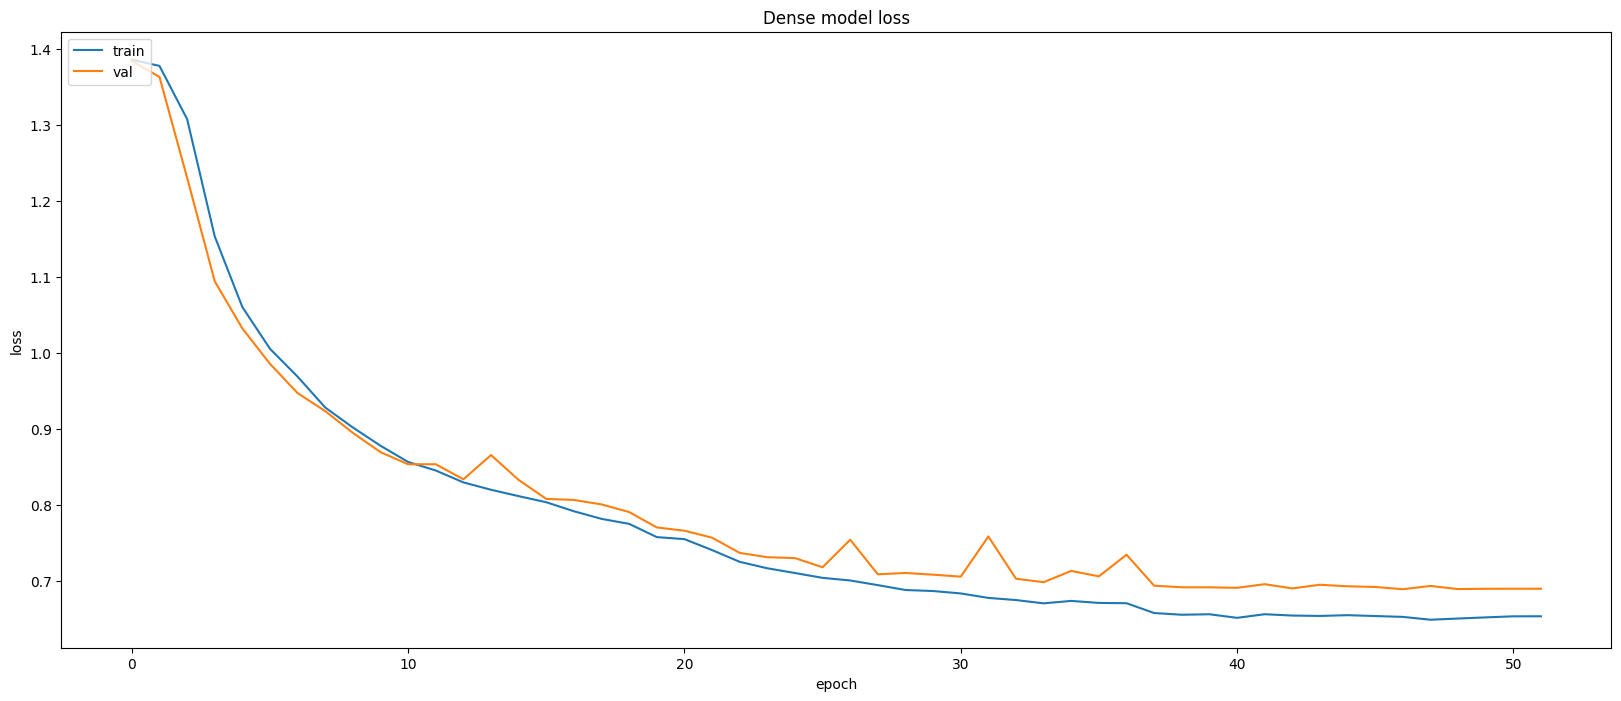

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Dense model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

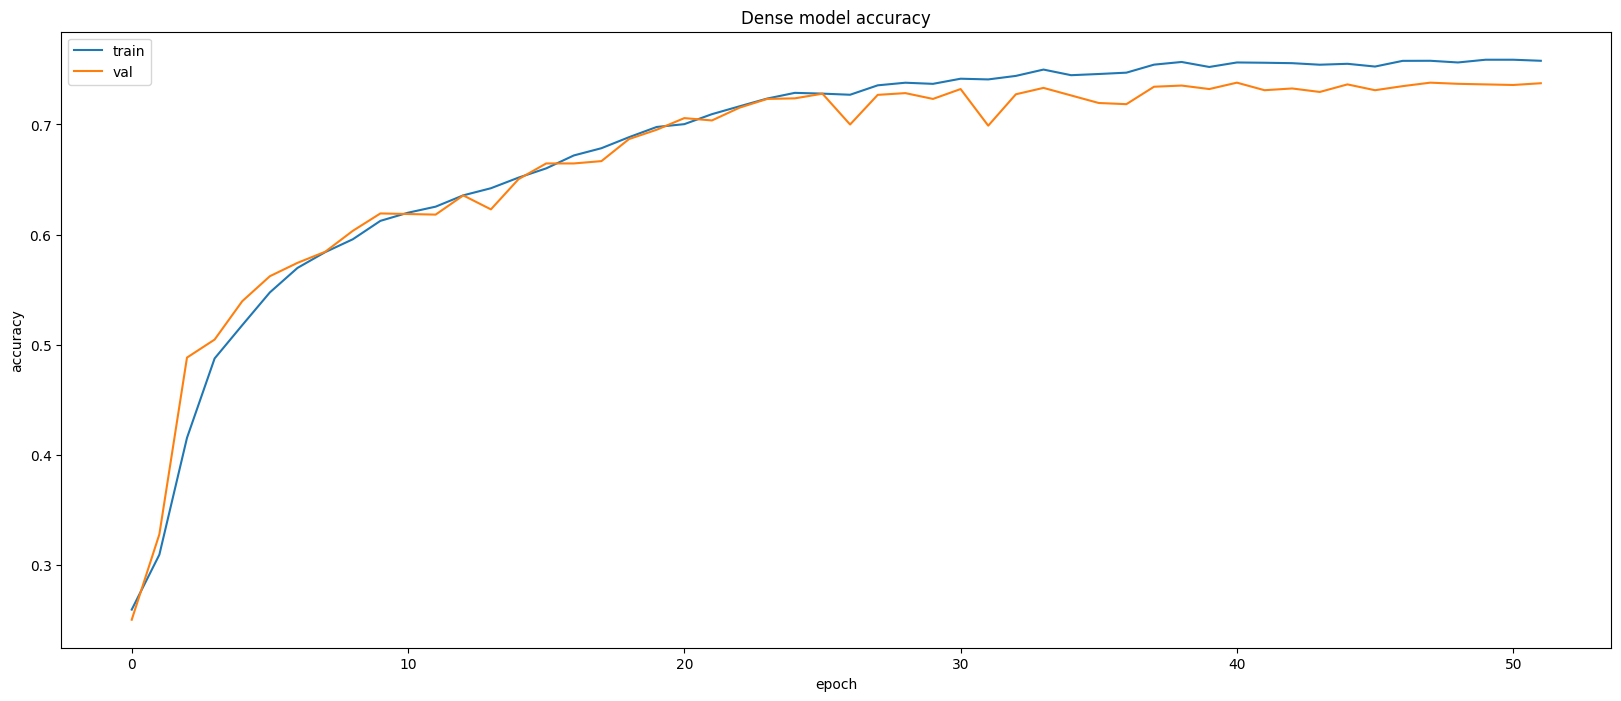

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Dense model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Avaliação do modelo no conjunto de teste
loss, accuracy = model.evaluate(test_padded, test_df['label'])

# Imprimir as métricas
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')

60/60 [==============================] - 0s 2ms/step - loss: 0.6658 - accuracy: 0.7495
Loss: 0.6658
Accuracy: 0.7495


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Obter as previsões do modelo
predictions = model.predict(test_padded)

# Converter as probabilidades em classes preditas (supondo que seja classificação multiclasse)
predicted_classes = predictions.argmax(axis=1)

# Calcular e imprimir outras métricas
print(classification_report(test_df['label'], predicted_classes))

60/60 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.78      0.76      0.77       475
           1       0.78      0.84      0.81       475
           2       0.74      0.64      0.69       475
           3       0.69      0.76      0.72       475

    accuracy                           0.75      1900
   macro avg       0.75      0.75      0.75      1900
weighted avg       0.75      0.75      0.75      1900



In [ ]:
train_df

,text,label,Categories,size
1593,Australia holds security meeting as warns of s...,0,World,304
465,Space Capsule Crashes in Utah The Genesis spac...,0,World,157
1615,"Typhoon Ma-On Nears Japan, May Strike Tokyo T...",0,World,266
490,Russian Hostel Fire Kills at Least 19 MOSCOW ...,0,World,197
1926,Padres Blank Dodgers 3-0 LOS ANGELES - Adam Ea...,0,World,357
...,...,...,...,...
13023,Capsule from Genesis Space Probe Crashes in Ut...,3,Sci/Tech,204
12251,IT departments turn to gateways to manage IM S...,3,Sci/Tech,331
13954,Violence Tackled at Internet Gaming Parlors By...,3,Sci/Tech,266
13423,"Microsoft, Polycom work on collaboration apps ...",3,Sci/Tech,170


60/60 [==============================] - 0s 2ms/step


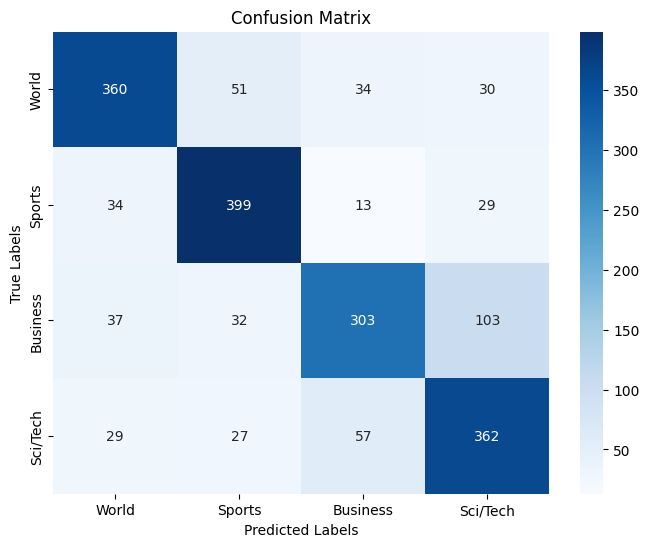

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Obter as previsões do modelo
predictions = model.predict(test_padded)
predicted_classes = predictions.argmax(axis=1)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(test_df['label'], predicted_classes)

# Definir rótulos das classes (opcional)
class_names = test_df['Categories'].unique()  # Substitua pelas suas classes

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
